<a href="https://colab.research.google.com/github/chdmitr2/Deep-Learning-22961/blob/main/maman14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Maman 14

Dmitriy Chudnovsky 324793900

Question 1

a - c : Implementation + Explicit initialisation + Quick sanity-check run

---

***Why Kaiming-He initialisation? ***

For ReLU activations we want Var(outputs) ≈ Var(inputs).
Kaiming initialisation achieves that by sampling:
 w_ij ∼ U[−1/√fan_in, 1/√fan_in]


In [9]:
import torch
import torch.nn as nn
import math
from torch import optim
from torchvision import datasets, transforms
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

class SplitLinear(nn.Module):
    """
    Splits the feature-axis in two, pushes each half through the *same*
    linear sub-layer (weight sharing), applies ReLU, then concatenates.
    Output shape == input shape.
    """
    def __init__(self, in_features: int, bias: bool = True):
        super().__init__()
        assert in_features % 2 == 0, "in_features must be even"
        half = in_features // 2
        self.half = half

        # shared linear block
        self.linear = nn.Linear(half, half, bias=bias)

        # --- explicit Kaiming-He initialisation (good for ReLU) ----
        nn.init.kaiming_uniform_(self.linear.weight, a=0.0, nonlinearity="relu")
        if bias:
            bound = 1 / math.sqrt(half)
            nn.init.uniform_(self.linear.bias, -bound, bound)
        # -----------------------------------------------------------
        self.relu = nn.ReLU()

    def forward(self, x):                       # x : (N, M)
        print("\nInput x:")
        print(x)

        x1, x2 = torch.split(x, self.half, dim=1)
        print("\nSplit x1:")
        print(x1)
        print("\nSplit x2:")
        print(x2)

        z1 = self.linear(x1)
        z2 = self.linear(x2)
        print("\nLinear(z1):")
        print(z1)
        print("\nLinear(z2):")
        print(z2)

        a1 = self.relu(z1)
        a2 = self.relu(z2)
        print("\nReLU(a1):")
        print(a1)
        print("\nReLU(a2):")
        print(a2)

        y = torch.cat([a1, a2], dim=1)
        print("\nConcatenated y:")
        print(y)

        return y

# ---- Test ----
torch.manual_seed(0)
demo = SplitLinear(6)
x = torch.randn(2, 6)
with torch.no_grad():
    y = demo(x)



Input x:
tensor([[-0.8567,  1.1006, -1.0712,  0.1227, -0.5663,  0.3731],
        [-0.8920, -1.5091,  0.3704,  1.4565,  0.9398,  0.7748]])

Split x1:
tensor([[-0.8567,  1.1006, -1.0712],
        [-0.8920, -1.5091,  0.3704]])

Split x2:
tensor([[ 0.1227, -0.5663,  0.3731],
        [ 1.4565,  0.9398,  0.7748]])

Linear(z1):
tensor([[ 1.2305, -0.4573,  0.0254],
        [ 2.8821, -0.6950,  2.4069]])

Linear(z2):
tensor([[ 0.6265, -0.1124,  0.8548],
        [-2.8204,  1.1404, -1.1451]])

ReLU(a1):
tensor([[1.2305, 0.0000, 0.0254],
        [2.8821, 0.0000, 2.4069]])

ReLU(a2):
tensor([[0.6265, 0.0000, 0.8548],
        [0.0000, 1.1404, 0.0000]])

Concatenated y:
tensor([[1.2305, 0.0000, 0.0254, 0.6265, 0.0000, 0.8548],
        [2.8821, 0.0000, 2.4069, 0.0000, 1.1404, 0.0000]])


d Block diagram

---



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


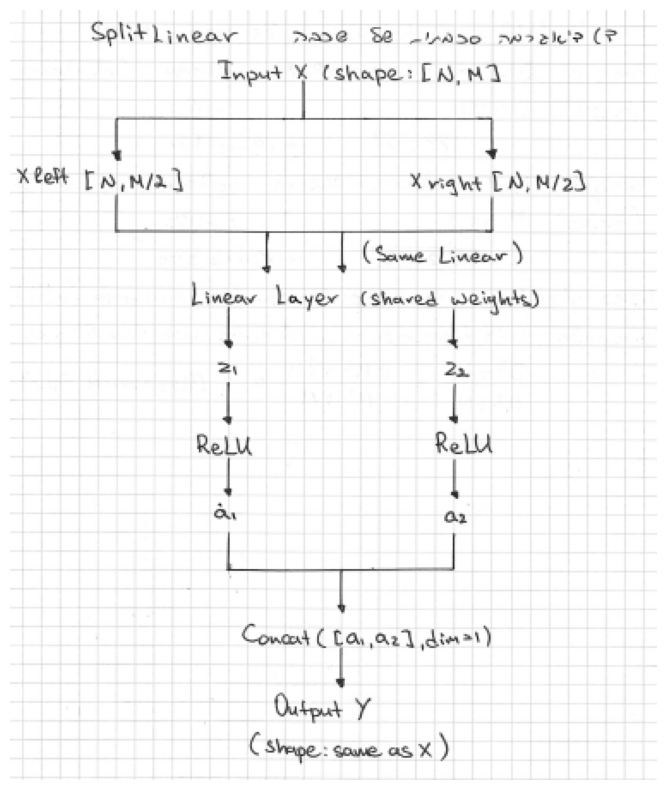

In [10]:

from google.colab import drive
drive.mount('/content/drive')
img = Image.open('/content/drive/MyDrive/mmn14_1_5.PNG')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

e Parameter count

---

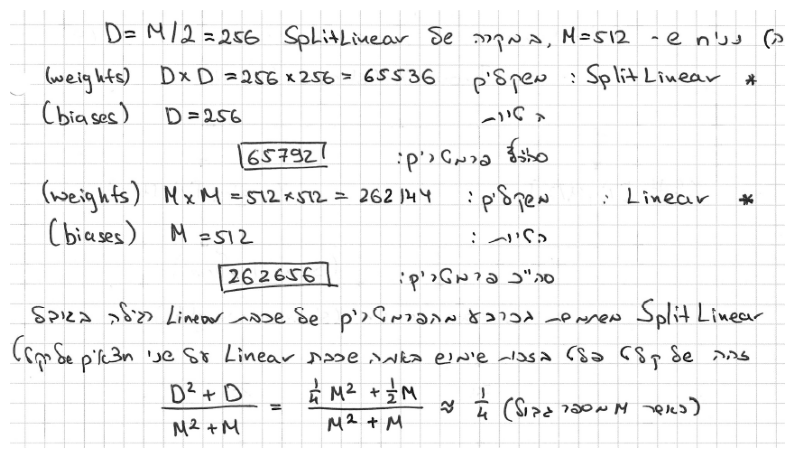

In [11]:
img = Image.open('/content/drive/MyDrive/mmn14_1_6.PNG')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

f Analytical gradients

---


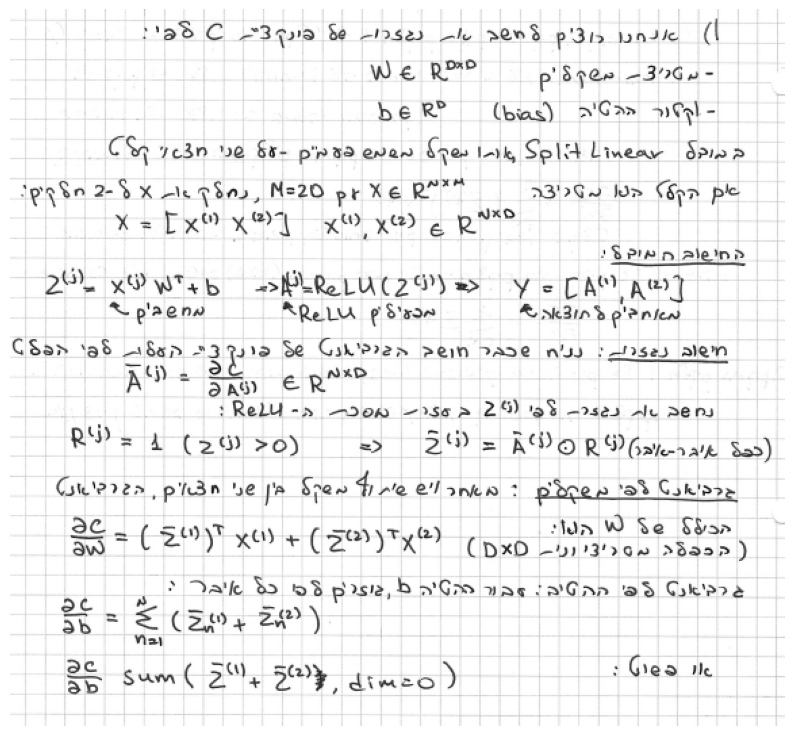

In [12]:
img = Image.open('/content/drive/MyDrive/mmn14_1_7.PNG')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

g If we split into 4 parts instead of 2

---



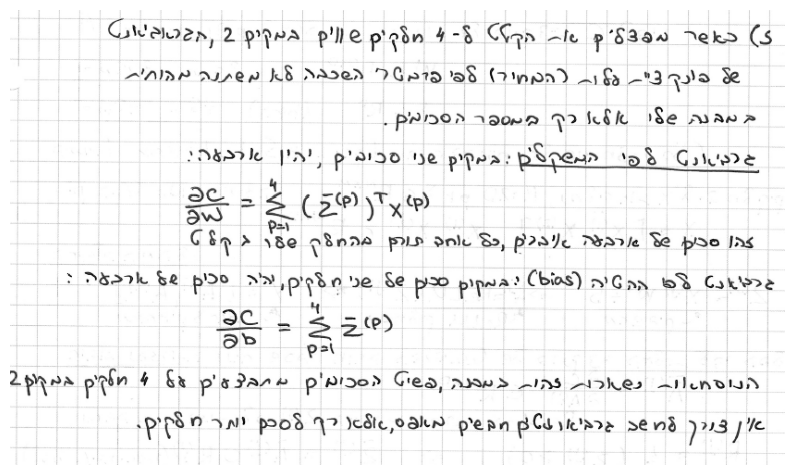

In [13]:
img = Image.open('/content/drive/MyDrive/mmn14_1_8.PNG')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

Question 2

a–e Full layer implementation + Baseline experiment

---

In [14]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

# === DropNorm Module ===
class DropNorm(nn.Module):
    def __init__(self, num_features: int, drop_rate: float = 0.5, eps: float = 1e-5, momentum: float = 0.1):
        super().__init__()
        self.drop_rate = drop_rate
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.register_buffer("running_mean", torch.zeros(num_features))
        self.register_buffer("running_var", torch.ones(num_features))

    def forward(self, x):
        orig_shape = x.shape
        x = x.flatten(1)  # (N, F)

        if self.training:
            N, F = x.shape
            mask = (torch.rand(N, F, device=x.device) > self.drop_rate).float()
            scale = 1.0 / (1.0 - self.drop_rate)
            x_masked = x * mask * scale

            mean = x_masked.mean(dim=0)
            var = x_masked.var(dim=0, unbiased=False)
            x_hat = (x_masked - mean) / torch.sqrt(var + self.eps)
            y = self.gamma * x_hat + self.beta

            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var
        else:
            x_hat = (x - self.running_mean) / torch.sqrt(self.running_var + self.eps)
            y = self.gamma * x_hat + self.beta

        return y.view(orig_shape)

# === FCNet Model with Switch ===
class FCNet(nn.Module):
    def __init__(self, use_dropnorm=False):
        super().__init__()
        norm = lambda nf: (DropNorm(nf) if use_dropnorm else nn.BatchNorm1d(nf))
        drop = (nn.Identity() if use_dropnorm else nn.Dropout(0.5))

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512), norm(512), nn.ReLU(), drop,
            nn.Linear(512, 256),  norm(256), nn.ReLU(), drop,
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)

# === Training and Evaluation ===
def train_one_epoch(model, loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    print(f"\n📘 Training Epoch {epoch + 1}")
    for x, y in tqdm(loader, desc=f"Training Epoch {epoch+1}", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    print(f"✅ Finished Epoch {epoch + 1} | Average Loss: {avg_loss:.4f}")
    return avg_loss

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    print("🔍 Evaluating model...")
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    accuracy = 100. * correct / total
    print(f"🎯 Test Accuracy: {accuracy:.2f}%")
    return accuracy

# === Data Loaders ===
print("📦 Loading FashionMNIST dataset...")
transform = transforms.ToTensor()
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(".", train=True, download=True, transform=transform),
    batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(".", train=False, transform=transform),
    batch_size=256)

# === Device and Settings ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
epochs = 10

# === Experiment Runner ===
def run_experiment(use_dropnorm):
    label = "DropNorm" if use_dropnorm else "BatchNorm + Dropout"
    print(f"\n🚀 Starting Training with: {label}")
    model = FCNet(use_dropnorm=use_dropnorm).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, epoch)
        test_acc = evaluate(model, test_loader)
        print(f"📈 Epoch {epoch + 1}/{epochs} | Loss: {train_loss:.4f} | Test Acc: {test_acc:.2f}%")
    print(f"🏁 Finished Training with {label}\n")

# === Run Both Experiments ===
run_experiment(use_dropnorm=False)  # BatchNorm + Dropout
run_experiment(use_dropnorm=True)   # DropNorm



📦 Loading FashionMNIST dataset...

🚀 Starting Training with: BatchNorm + Dropout

📘 Training Epoch 1


✅ Finished Epoch 1 | Average Loss: 0.5436
🔍 Evaluating model...
🎯 Test Accuracy: 85.21%
📈 Epoch 1/10 | Loss: 0.5436 | Test Acc: 85.21%

📘 Training Epoch 2


✅ Finished Epoch 2 | Average Loss: 0.4182
🔍 Evaluating model...
🎯 Test Accuracy: 85.08%
📈 Epoch 2/10 | Loss: 0.4182 | Test Acc: 85.08%

📘 Training Epoch 3


✅ Finished Epoch 3 | Average Loss: 0.3870
🔍 Evaluating model...
🎯 Test Accuracy: 85.76%
📈 Epoch 3/10 | Loss: 0.3870 | Test Acc: 85.76%

📘 Training Epoch 4


✅ Finished Epoch 4 | Average Loss: 0.3657
🔍 Evaluating model...
🎯 Test Accuracy: 86.43%
📈 Epoch 4/10 | Loss: 0.3657 | Test Acc: 86.43%

📘 Training Epoch 5


✅ Finished Epoch 5 | Average Loss: 0.3472
🔍 Evaluating model...
🎯 Test Accuracy: 87.55%
📈 Epoch 5/10 | Loss: 0.3472 | Test Acc: 87.55%

📘 Training Epoch 6


✅ Finished Epoch 6 | Average Loss: 0.3343
🔍 Evaluating model...
🎯 Test Accuracy: 87.32%
📈 Epoch 6/10 | Loss: 0.3343 | Test Acc: 87.32%

📘 Training Epoch 7


✅ Finished Epoch 7 | Average Loss: 0.3248
🔍 Evaluating model...
🎯 Test Accuracy: 87.68%
📈 Epoch 7/10 | Loss: 0.3248 | Test Acc: 87.68%

📘 Training Epoch 8


✅ Finished Epoch 8 | Average Loss: 0.3137
🔍 Evaluating model...
🎯 Test Accuracy: 87.84%
📈 Epoch 8/10 | Loss: 0.3137 | Test Acc: 87.84%

📘 Training Epoch 9


✅ Finished Epoch 9 | Average Loss: 0.3067
🔍 Evaluating model...
🎯 Test Accuracy: 87.77%
📈 Epoch 9/10 | Loss: 0.3067 | Test Acc: 87.77%

📘 Training Epoch 10


✅ Finished Epoch 10 | Average Loss: 0.3007
🔍 Evaluating model...
🎯 Test Accuracy: 88.57%
📈 Epoch 10/10 | Loss: 0.3007 | Test Acc: 88.57%
🏁 Finished Training with BatchNorm + Dropout


🚀 Starting Training with: DropNorm

📘 Training Epoch 1


✅ Finished Epoch 1 | Average Loss: 0.5859
🔍 Evaluating model...
🎯 Test Accuracy: 83.41%
📈 Epoch 1/10 | Loss: 0.5859 | Test Acc: 83.41%

📘 Training Epoch 2


✅ Finished Epoch 2 | Average Loss: 0.4408
🔍 Evaluating model...
🎯 Test Accuracy: 85.08%
📈 Epoch 2/10 | Loss: 0.4408 | Test Acc: 85.08%

📘 Training Epoch 3


✅ Finished Epoch 3 | Average Loss: 0.4070
🔍 Evaluating model...
🎯 Test Accuracy: 84.74%
📈 Epoch 3/10 | Loss: 0.4070 | Test Acc: 84.74%

📘 Training Epoch 4


✅ Finished Epoch 4 | Average Loss: 0.3859
🔍 Evaluating model...
🎯 Test Accuracy: 86.29%
📈 Epoch 4/10 | Loss: 0.3859 | Test Acc: 86.29%

📘 Training Epoch 5


✅ Finished Epoch 5 | Average Loss: 0.3713
🔍 Evaluating model...
🎯 Test Accuracy: 85.43%
📈 Epoch 5/10 | Loss: 0.3713 | Test Acc: 85.43%

📘 Training Epoch 6


✅ Finished Epoch 6 | Average Loss: 0.3581
🔍 Evaluating model...
🎯 Test Accuracy: 86.46%
📈 Epoch 6/10 | Loss: 0.3581 | Test Acc: 86.46%

📘 Training Epoch 7


✅ Finished Epoch 7 | Average Loss: 0.3454
🔍 Evaluating model...
🎯 Test Accuracy: 87.07%
📈 Epoch 7/10 | Loss: 0.3454 | Test Acc: 87.07%

📘 Training Epoch 8


✅ Finished Epoch 8 | Average Loss: 0.3413
🔍 Evaluating model...
🎯 Test Accuracy: 86.90%
📈 Epoch 8/10 | Loss: 0.3413 | Test Acc: 86.90%

📘 Training Epoch 9


✅ Finished Epoch 9 | Average Loss: 0.3304
🔍 Evaluating model...
🎯 Test Accuracy: 87.06%
📈 Epoch 9/10 | Loss: 0.3304 | Test Acc: 87.06%

📘 Training Epoch 10


✅ Finished Epoch 10 | Average Loss: 0.3210
🔍 Evaluating model...
🎯 Test Accuracy: 87.39%
📈 Epoch 10/10 | Loss: 0.3210 | Test Acc: 87.39%
🏁 Finished Training with DropNorm



f Comparison of Networks

---



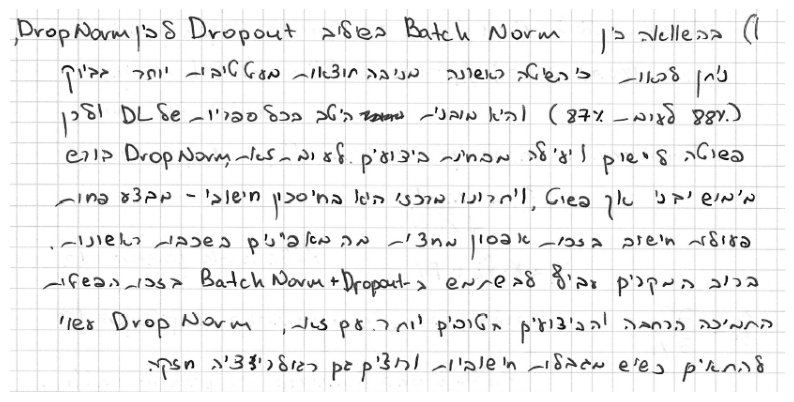

In [15]:
img = Image.open('/content/drive/MyDrive/mmn14_1_9.PNG')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

g Analytical gradient

---


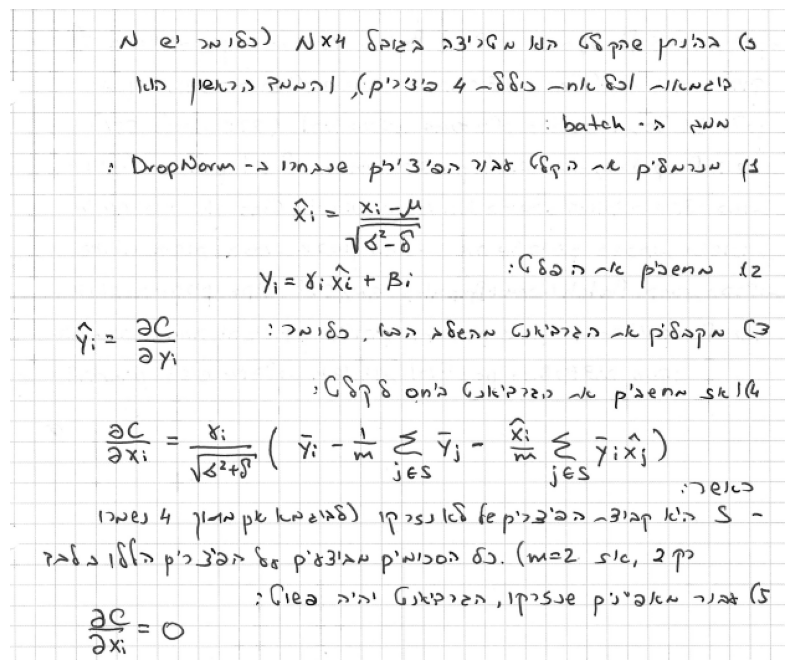

In [16]:
img = Image.open('/content/drive/MyDrive/mmn14_1_10.PNG')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()